# EXP 调参

In [1]:
import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
# Importing the custom module
from Utools.draw import plot_feature_importance
from Utools.SingleModel import SingleModel

In [9]:
# Load data
file_dir = os.path.join(current_path, './Data')
# Load exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_all_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_all_train_y = exp_train['band_gap']
# Load exp test data
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']
exp_all_train_X.shape, exp_all_train_y.shape, exp_test_X.shape, exp_test_y.shape

((2545, 64), (2545,), (585, 64), (585,))

In [3]:
# 从exp_train_X中抽取出一份验证集
exp_unique_comp = exp_train['composition'].unique()
len(exp_unique_comp)

1581

In [4]:
import random
# 从exp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(exp_unique_comp)), round(len(exp_unique_comp)*0.2))
exp_val_comp = exp_unique_comp[random_index]
exp_train_set = exp_train[~exp_train['composition'].isin(exp_val_comp)]
exp_val_set = exp_train[exp_train['composition'].isin(exp_val_comp)]
print(f'MP训练集大小：{len(exp_train_set)}')
print(f'MP验证集大小：{len(exp_val_set)}')

MP训练集大小：1930
MP验证集大小：615


In [5]:
# Prepare data
exp_train_X = exp_train_set.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train_set['band_gap']
# 
exp_val_X = exp_val_set.drop(columns=['composition', 'band_gap'])
exp_val_y = exp_val_set['band_gap']

exp_train_X.shape, exp_train_y.shape, exp_val_X.shape, exp_val_y.shape

((1930, 64), (1930,), (615, 64), (615,))

## 5. Ridge

In [6]:
from sklearn.linear_model import Ridge
# Define the model
MODEL_NAME = 'Ridge'

In [11]:
ridge_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'alpha', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'alpha': list(np.arange(0.001, 1.001, 0.001))
}
n_iter = len(params['alpha'])  # Number of iterations
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(exp_train_X)
scaled_dft_val_X = scaler.transform(exp_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(
    params['alpha']
))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'alpha': sampled_params_tuple[0],
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create the model with sampled parameters  
    model = Ridge(alpha=sampled_params['alpha'], random_state=RANDOM_SEED)
    # fit the model
    model.fit(scaled_dft_train_X, exp_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(exp_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(exp_val_y, val_pred))
    train_r2 = r2_score(exp_train_y, train_pred)
    val_r2 = r2_score(exp_val_y, val_pred)
    train_mae = mean_absolute_error(exp_train_y, train_pred)
    val_mae = mean_absolute_error(exp_val_y, val_pred)

    # Append metrics to DataFrame
    ridge_metrics.loc[len(ridge_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'alpha': sampled_params['alpha'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    ridge_metrics.loc[len(ridge_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'alpha': sampled_params['alpha'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = ridge_metrics[ridge_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = ridge_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: {best_val_params['alpha']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search', 'exp')
os.makedirs(hp_path, exist_ok=True)
ridge_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True) # Sort inplace
ridge_metrics.reset_index(drop=True, inplace=True) # Reset index inplace
ridge_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)

[Iter 1/1000] Sampled parameters: {'alpha': np.float64(0.264)}
Train RMSE: 0.49700043168601166, Validation RMSE: 0.49894163775069583
[Iter 2/1000] Sampled parameters: {'alpha': np.float64(0.936)}
Train RMSE: 0.4970377442496908, Validation RMSE: 0.4990677541153875
[Iter 3/1000] Sampled parameters: {'alpha': np.float64(0.845)}
Train RMSE: 0.49703059533321703, Validation RMSE: 0.49905030044040205
[Iter 4/1000] Sampled parameters: {'alpha': np.float64(0.967)}
Train RMSE: 0.49704031498815227, Validation RMSE: 0.49907372097740665
[Iter 5/1000] Sampled parameters: {'alpha': np.float64(0.494)}
Train RMSE: 0.4970089651373485, Validation RMSE: 0.4989839978302168
[Iter 6/1000] Sampled parameters: {'alpha': np.float64(0.991)}
Train RMSE: 0.4970423515271161, Validation RMSE: 0.4990783474772476
[Iter 7/1000] Sampled parameters: {'alpha': np.float64(0.8260000000000001)}
Train RMSE: 0.4970291790281736, Validation RMSE: 0.49904666851277685
[Iter 8/1000] Sampled parameters: {'alpha': np.float64(0.303)}


Train RMSE: 0.49701174750742066, Validation RMSE: 0.49899445338810794
[Iter 34/1000] Sampled parameters: {'alpha': np.float64(0.127)}
Train RMSE: 0.49699770184984243, Validation RMSE: 0.49891690946510264
[Iter 35/1000] Sampled parameters: {'alpha': np.float64(0.466)}
Train RMSE: 0.49700767441614646, Validation RMSE: 0.49897878963697156
[Iter 36/1000] Sampled parameters: {'alpha': np.float64(0.378)}
Train RMSE: 0.4970040648838223, Validation RMSE: 0.4989625105283094
[Iter 37/1000] Sampled parameters: {'alpha': np.float64(0.6890000000000001)}
Train RMSE: 0.4970197750880267, Validation RMSE: 0.4990206165342333
[Iter 38/1000] Sampled parameters: {'alpha': np.float64(0.767)}
Train RMSE: 0.49702495315884104, Validation RMSE: 0.49903541897417236
[Iter 39/1000] Sampled parameters: {'alpha': np.float64(0.964)}
Train RMSE: 0.49704006325009187, Validation RMSE: 0.49907314308978706
[Iter 40/1000] Sampled parameters: {'alpha': np.float64(0.269)}
Train RMSE: 0.49700056564085293, Validation RMSE: 0.4

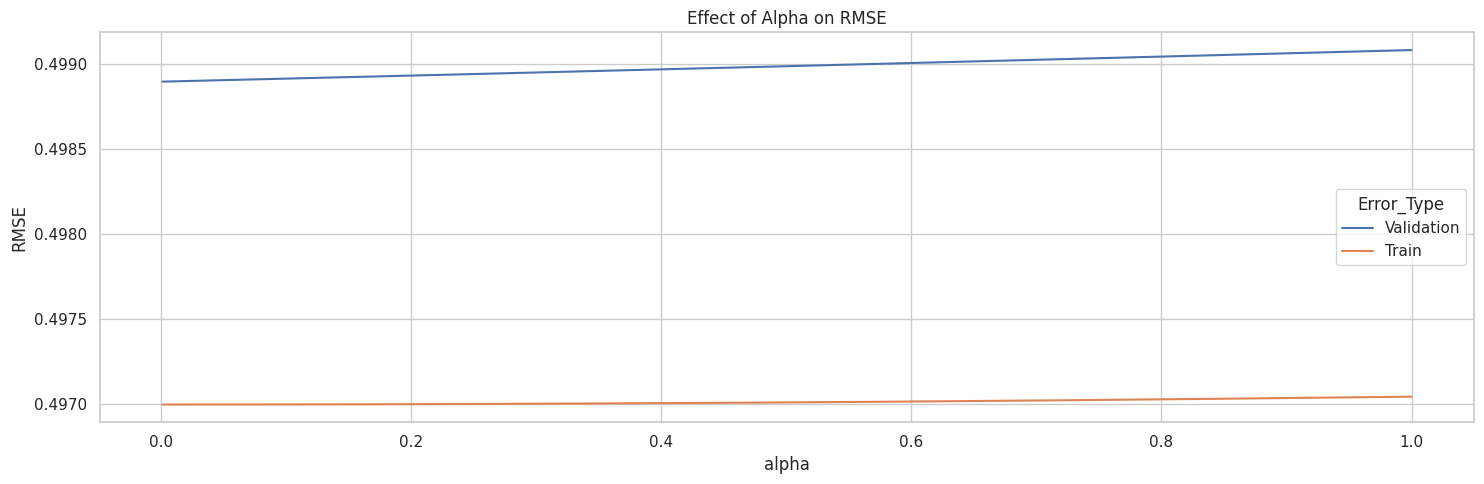

In [12]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
sns.lineplot(data=ridge_metrics, x='alpha', y='RMSE', hue='Error_Type')
plt.title('Effect of Alpha on RMSE')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

### Test

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train Error] Evaluating DFT Ridge on train set:


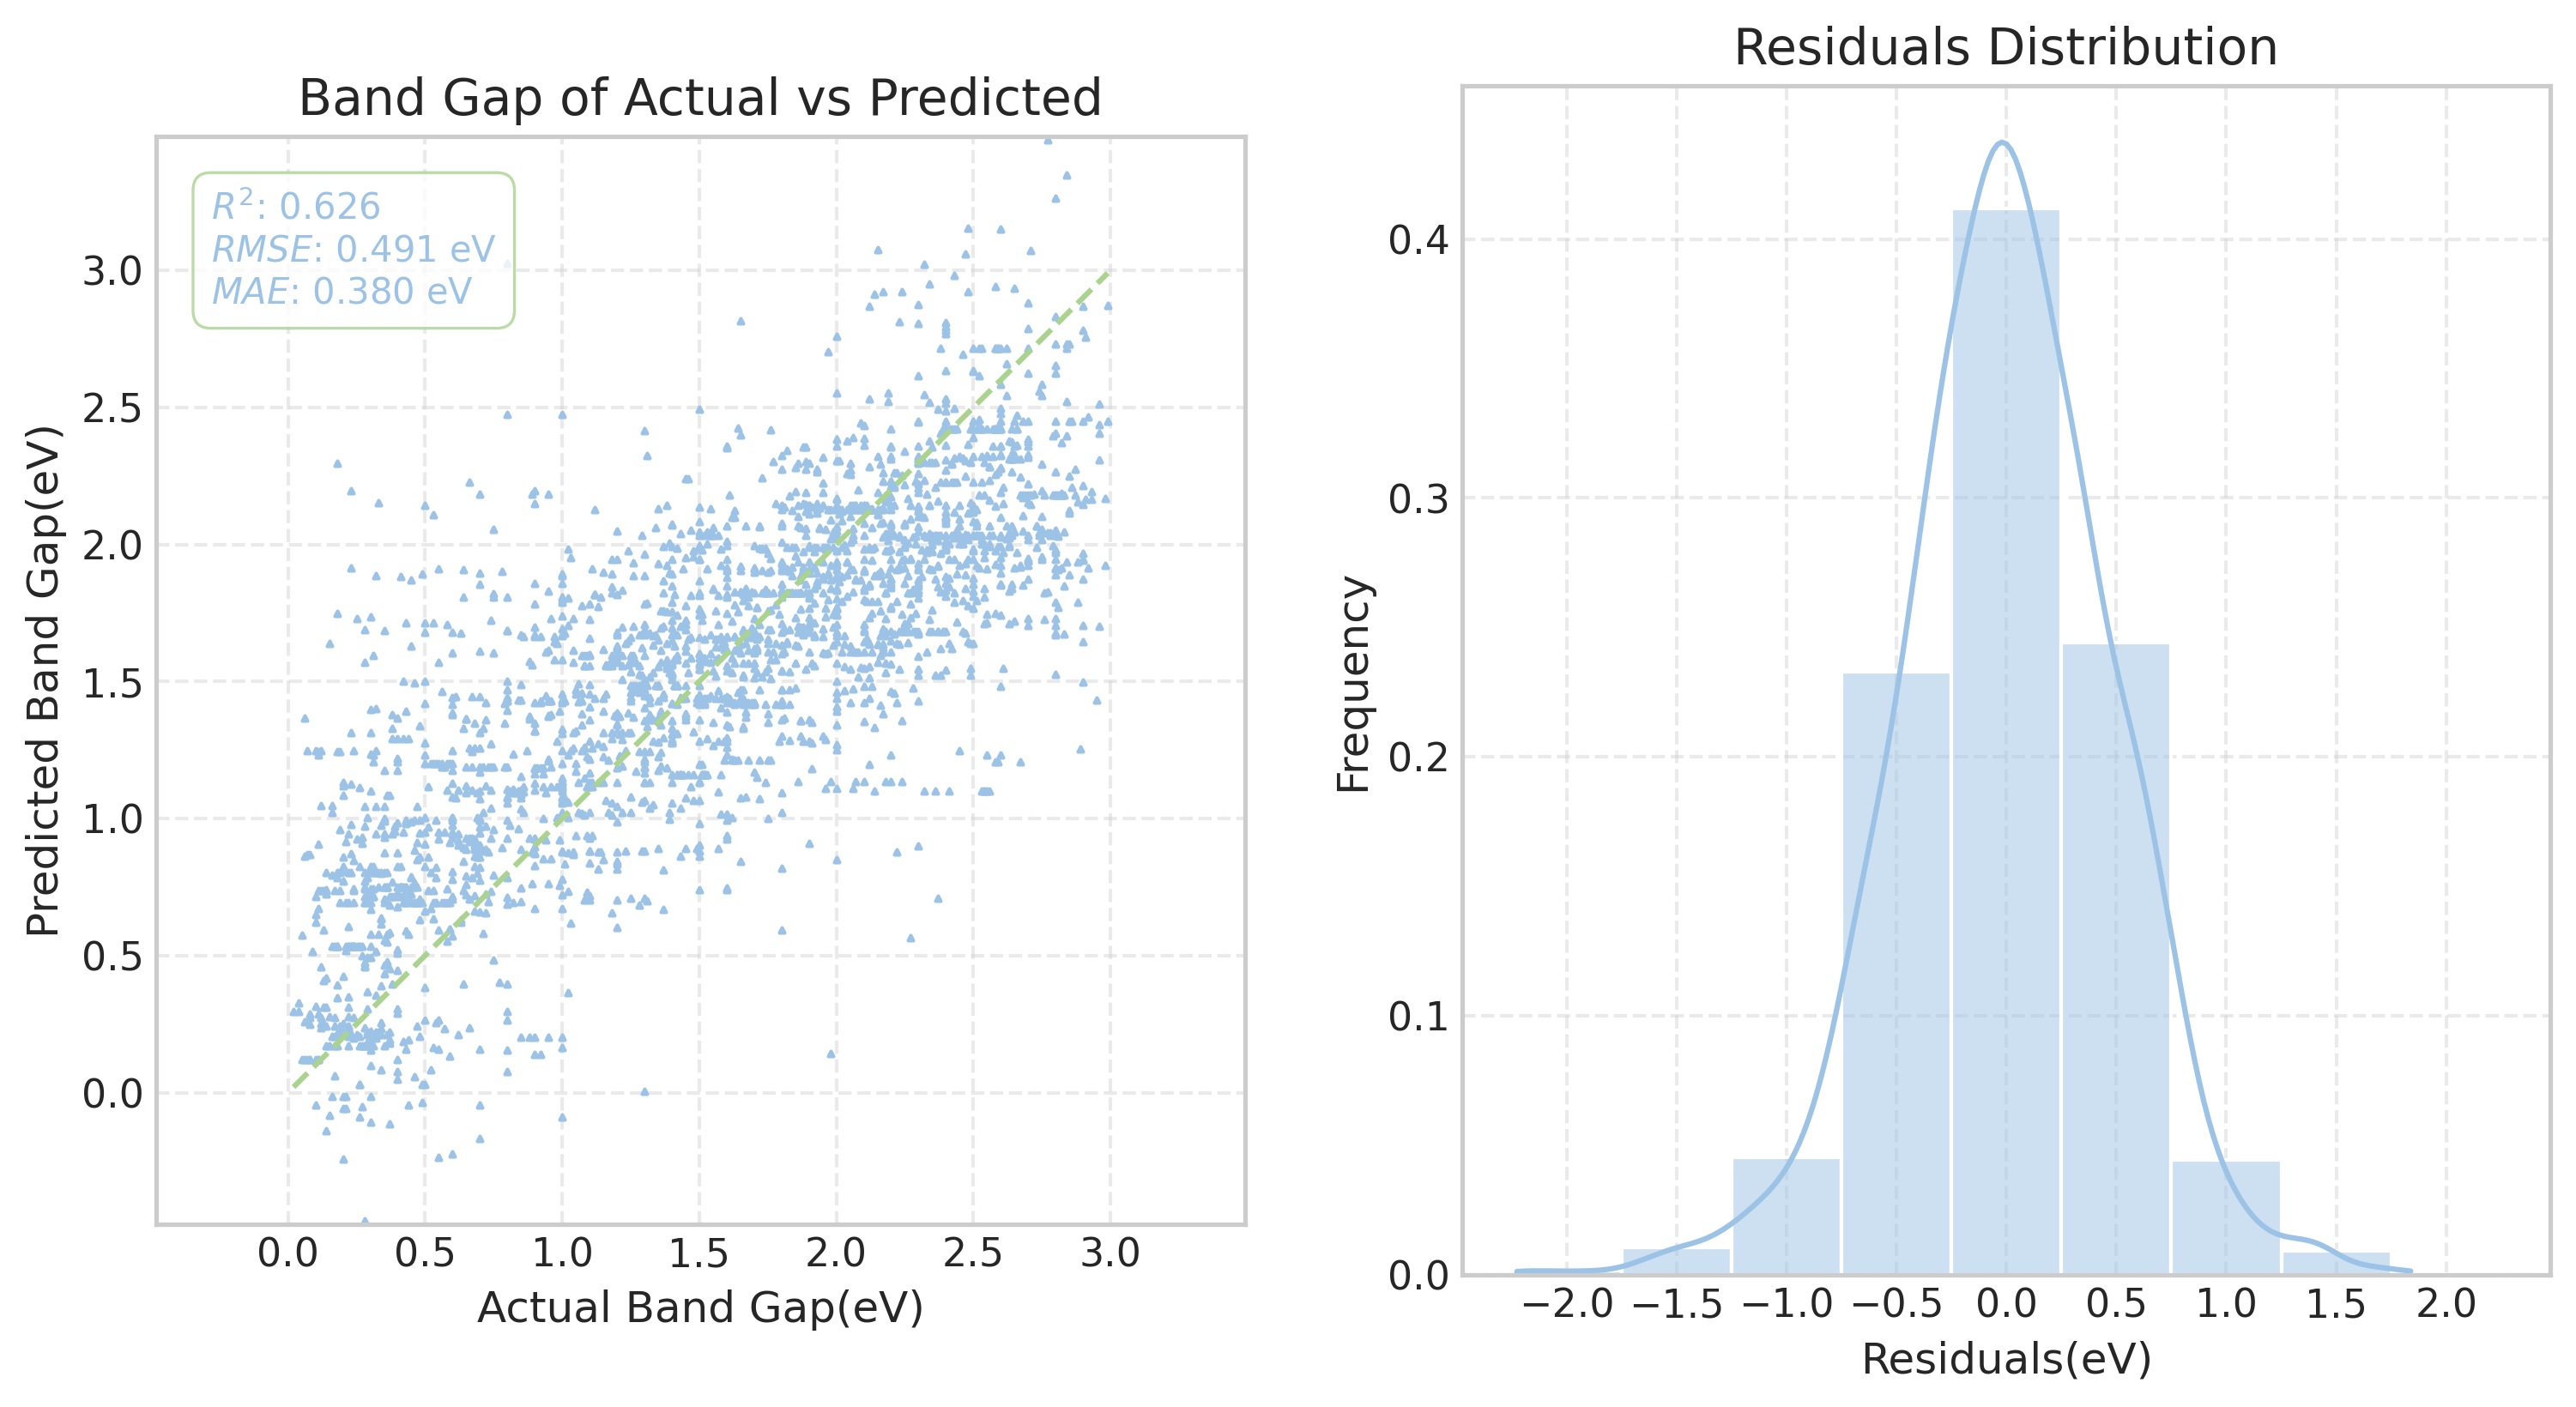


Model Evaluation Results:
Test set size: 2545
Test set: R²: 0.6263 RMSE: 0.4910 MAE: 0.3799 MAPE: 53.4309%
[Test Error] Evaluating DFT Ridge on test set:


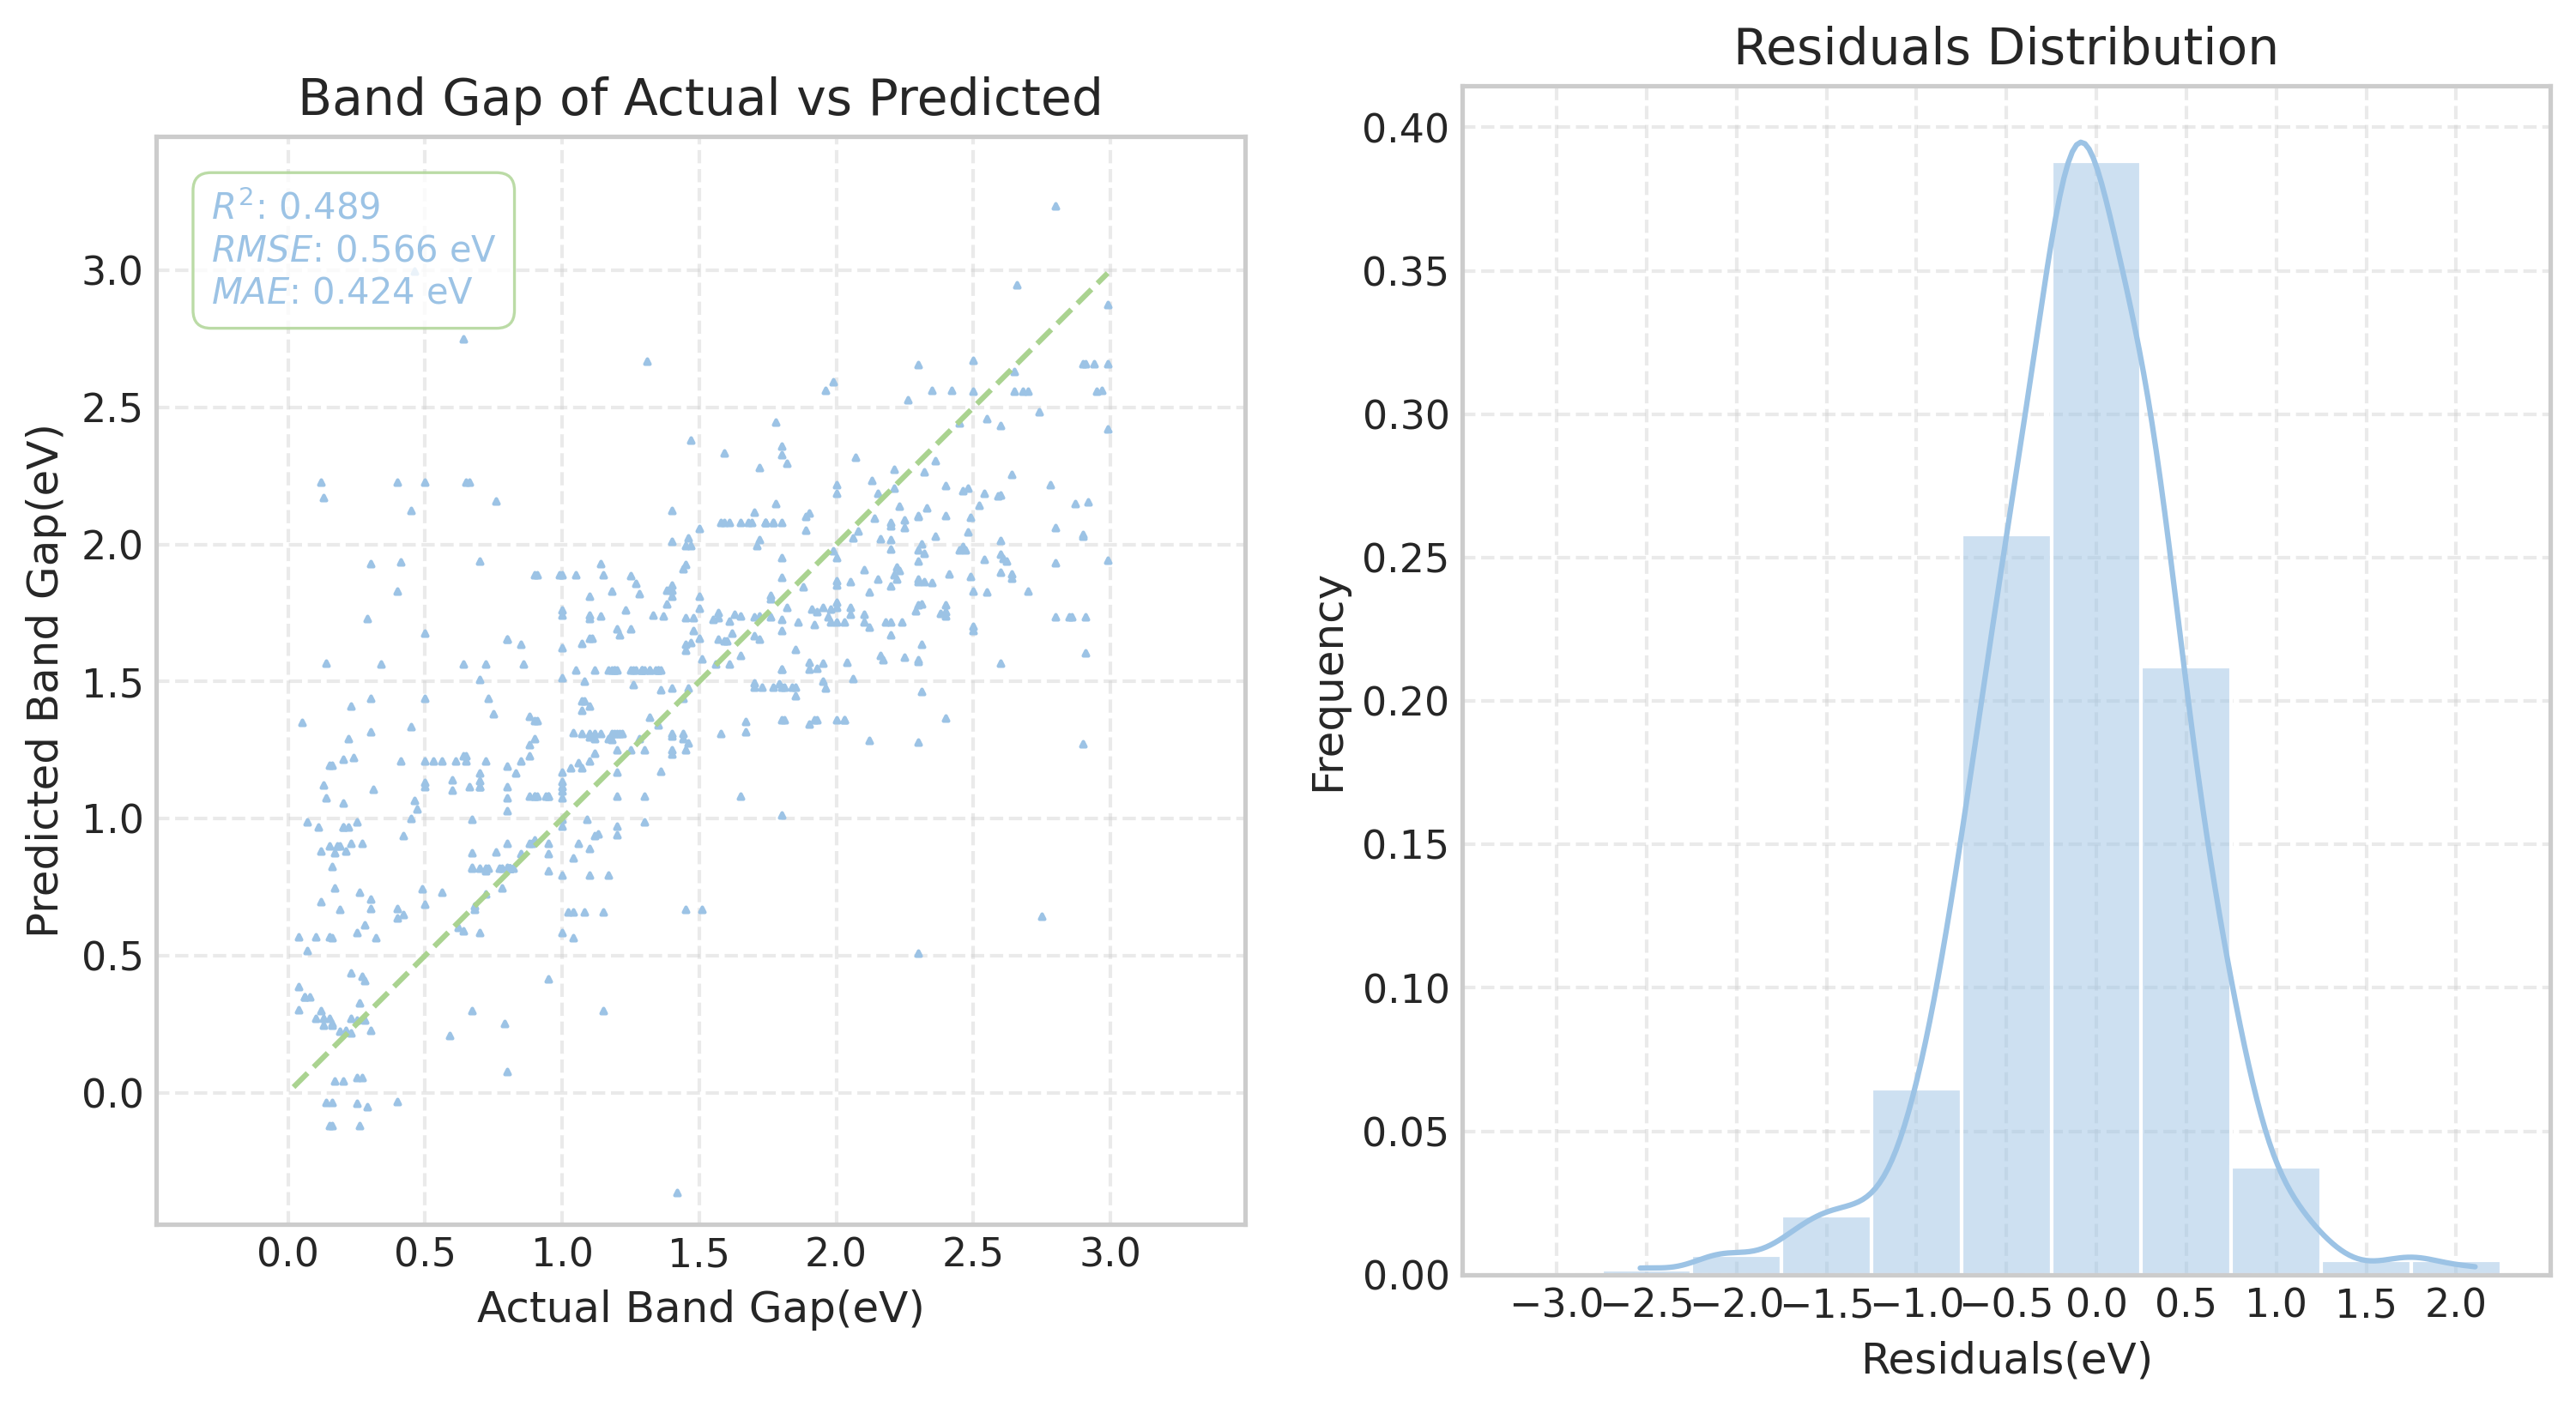


Model Evaluation Results:
Test set size: 585
Test set: R²: 0.4894 RMSE: 0.5664 MAE: 0.4238 MAPE: 95.2127%


In [10]:
best_ridge = Ridge(alpha=best_val_params['alpha'], random_state=RANDOM_SEED)
model = SingleModel(model=best_ridge)
model.train(exp_all_train_X, exp_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(exp_all_train_X, exp_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(exp_test_X, exp_test_y, fig_show=True)